In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import floor
%matplotlib inline

In [2]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D, proj3d
from scipy import interpolate
import timeit

In [3]:
from smile import SmileCalibration

In [4]:
from pylab import rcParams
SMALL_SIZE = 7
MEDIUM_SIZE = 9
BIGGER_SIZE = 120

rcParams["text.usetex"] = True
rcParams["font.family"] = "serif"
rcParams['font.size'] = SMALL_SIZE  
rcParams['axes.titlesize'] = MEDIUM_SIZE    
rcParams['axes.labelsize'] = MEDIUM_SIZE    
rcParams['axes.linewidth'] = 0.4
rcParams['xtick.labelsize'] = SMALL_SIZE    
rcParams['ytick.labelsize'] = SMALL_SIZE    
rcParams['legend.fontsize'] = 8    
rcParams['legend.edgecolor'] = "black"
rcParams["lines.linewidth"] = 0.6
rcParams['xtick.major.size'] = 2.5
rcParams['xtick.major.width'] = 0.4
rcParams['ytick.major.size'] = 2.5
rcParams['ytick.major.width'] = 0.4
rcParams["savefig.dpi"] = 500
rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [5]:
save_files = True

### SABR implied vol function

In [6]:
def transform_params(fit_params):
    
    alpha, rho, nu = fit_params
    alpha, nu = abs(alpha), abs(nu) # makes alpha and nu positive
    rho = abs(rho + 1 - 4*floor(1/2 + (rho + 1)/4)) - 1 # ensures rho is within +/- 1
    
    return alpha, rho, nu

In [7]:
def sabr_implied_vol(strike, forward, mty, fit_params, beta=1):
    # From https://www.next-finance.net/IMG/pdf/pdf_SABR.pdf
    
    alpha, rho, nu = fit_params

    p1 = alpha / ((forward * strike) ** ((1 - beta) / 2))
    p2 = 1 + mty * ((1 - beta) ** 2 * alpha ** 2 / (24 * (forward * strike) ** (1 - beta)) +
                    0.25 * rho * beta * nu * alpha / ((forward * strike) ** ((1 - beta) / 2)) +
                    (2 - 3 * rho ** 2) * nu ** 2 / 24)
    p3 = 1
    p4 = 1

    if strike != forward:
        p3 = 1 / (1 + (1 - beta) ** 2 * np.log(forward / strike) / 24 +
                  (1 - beta) ** 4 * np.log(forward / strike) / 1920)
        z = (nu / alpha) * (forward * strike) ** ((1 - beta) / 2) * np.log(forward / strike)
        x = np.log((np.sqrt(1 - 2 * rho * z + z ** 2) + z - rho) / (1 - rho))
        p4 = z / x

    result = p1 * p2 * p3 * p4

    if type(result) == np.ndarray:
        result = result[0]

    return result

### Setup inputs

In [8]:
t0 = "2019-01-15" # pricing date

In [9]:
common_inputs = {
    "price": 3.724, "rd": 0.065, "rf": 0.022, "rr_delta": 0.25, "bf_delta": 0.25,
    "price_type": "s",                          # price given above is spot price
    "delta_type": "s",                          # delta used is spot delta
    "premium_included": "i",                    # delta is premium included
    "atm_type": "d",                            # atm is delta-neutral strike
    "transform_params_func": transform_params   # function that maps parameters to correct range
} 

In [10]:
tenors = ["ON", "1W", "2W", "1M", "2M", "3M", "6M", "1Y"]
expiry = ["2019-01-16", "2019-01-22", "2019-01-29", "2019-02-15",
          "2019-03-14", "2019-04-15", "2019-07-15", "2020-01-15"]
vol_atm = [0.2098, 0.1391, 0.1375, 0.1424, 0.1384, 0.1382, 0.1382, 0.1394]
vol_rr = [0.012, 0.013, 0.014, 0.015, 0.0175, 0.02, 0.024, 0.029]
vol_bf = [0.0015, 0.002, 0.002, 0.0022, 0.0027, 0.0032, 0.0043, 0.0055]
col_names = ["expiry_date", "vol_atm", "vol_rr", "vol_bf"]

In [11]:
inputs_df = pd.DataFrame(list(zip(expiry, vol_atm, vol_rr, vol_bf)), columns=col_names, index=tenors)

# Compute maturities (in years)
inputs_df["mty"] = inputs_df["expiry_date"].apply(lambda x: (pd.to_datetime(x) - pd.to_datetime(t0)).days / 365)
inputs_df.columns.name = "tenors"

display(inputs_df)

if save_files:
    inputs_df.to_csv("csv/inputs_df.csv")

tenors,expiry_date,vol_atm,vol_rr,vol_bf,mty
ON,2019-01-16,0.2098,0.0120,0.0015,0.002740
1W,2019-01-22,0.1391,0.0130,0.0020,0.019178
2W,2019-01-29,0.1375,0.0140,0.0020,0.038356
1M,2019-02-15,0.1424,0.0150,0.0022,0.084932
2M,2019-03-14,0.1384,0.0175,0.0027,0.158904
3M,2019-04-15,0.1382,0.0200,0.0032,0.246575
6M,2019-07-15,0.1382,0.0240,0.0043,0.495890
1Y,2020-01-15,0.1394,0.0290,0.0055,1.000000


### Calibration

In [12]:
sabr_answers = { }
total = 0

for tenor in inputs_df.index:
    
    print(tenor)
    
    # Get tenor-specific inputs
    tenor_inputs = inputs_df.loc[tenor, ["vol_atm", "vol_rr", "vol_bf", "mty"]]
    
    # Setup calibration object
    sabr_answers[tenor] = SmileCalibration(implied_vol_func=sabr_implied_vol,
                                           **common_inputs, **tenor_inputs)

    # Calibration
    start = timeit.default_timer()
    
    # Guess = [alpha = vol_atm, rho = 0.5, nu = 0.5]
    sabr_answers[tenor].fit([sabr_answers[tenor].vol_atm, 0.5, 0.5])
    
    stop = timeit.default_timer()
    length = stop - start
    total += length
    
    print("Calibration time: {:.2f}s\n".format(length))

print("Total calibration time: {:.2f}s".format(total))

ON
Fit successful.
Calibration time: 0.07s

1W
Fit successful.
Calibration time: 0.05s

2W
Fit successful.
Calibration time: 0.06s

1M
Fit successful.
Calibration time: 0.06s

2M
Fit successful.
Calibration time: 0.08s

3M
Fit successful.
Calibration time: 0.10s

6M
Fit successful.
Calibration time: 0.07s

1Y
Fit successful.
Calibration time: 0.07s

Total calibration time: 0.56s


### Summary of results

In [13]:
params_df = pd.DataFrame((sabr_answers[ans].fitted_params for ans in sabr_answers),
                         index=sabr_answers.keys(), columns=["alpha", "rho", "nu"])
display(params_df)

if save_files:
    params_df.to_csv("csv/params_df.csv")

,alpha,rho,nu
ON,0.208316,0.270426,5.922766
1W,0.137235,0.310110,3.155176
2W,0.135721,0.338352,2.228122
1M,0.140563,0.348110,1.505217
2M,0.136302,0.375851,1.218256
3M,0.135880,0.399488,1.049798
6M,0.135414,0.424409,0.832018
1Y,0.136459,0.472777,0.631639


,k_10_put,k_bf_put,k_rr_put,k_atm,k_bf_call,k_rr_call,k_10_call
ON,3.673921,3.696775,3.697543,3.724214,3.752338,3.753148,3.781720
1W,3.639659,3.678341,3.680509,3.726381,3.776537,3.778896,3.834491
2W,3.609578,3.662193,3.665474,3.728795,3.799534,3.803152,3.882681
1M,3.554036,3.633319,3.638515,3.734408,3.845334,3.851153,3.977541
2M,3.509147,3.610881,3.619076,3.743831,3.894229,3.903650,4.084289
3M,3.468763,3.591263,3.602811,3.754843,3.945513,3.959105,4.199191
6M,3.393669,3.559530,3.578856,3.786288,4.067966,4.091683,4.480306
1Y,3.315874,3.536850,3.569374,3.850035,4.277074,4.319173,4.981484


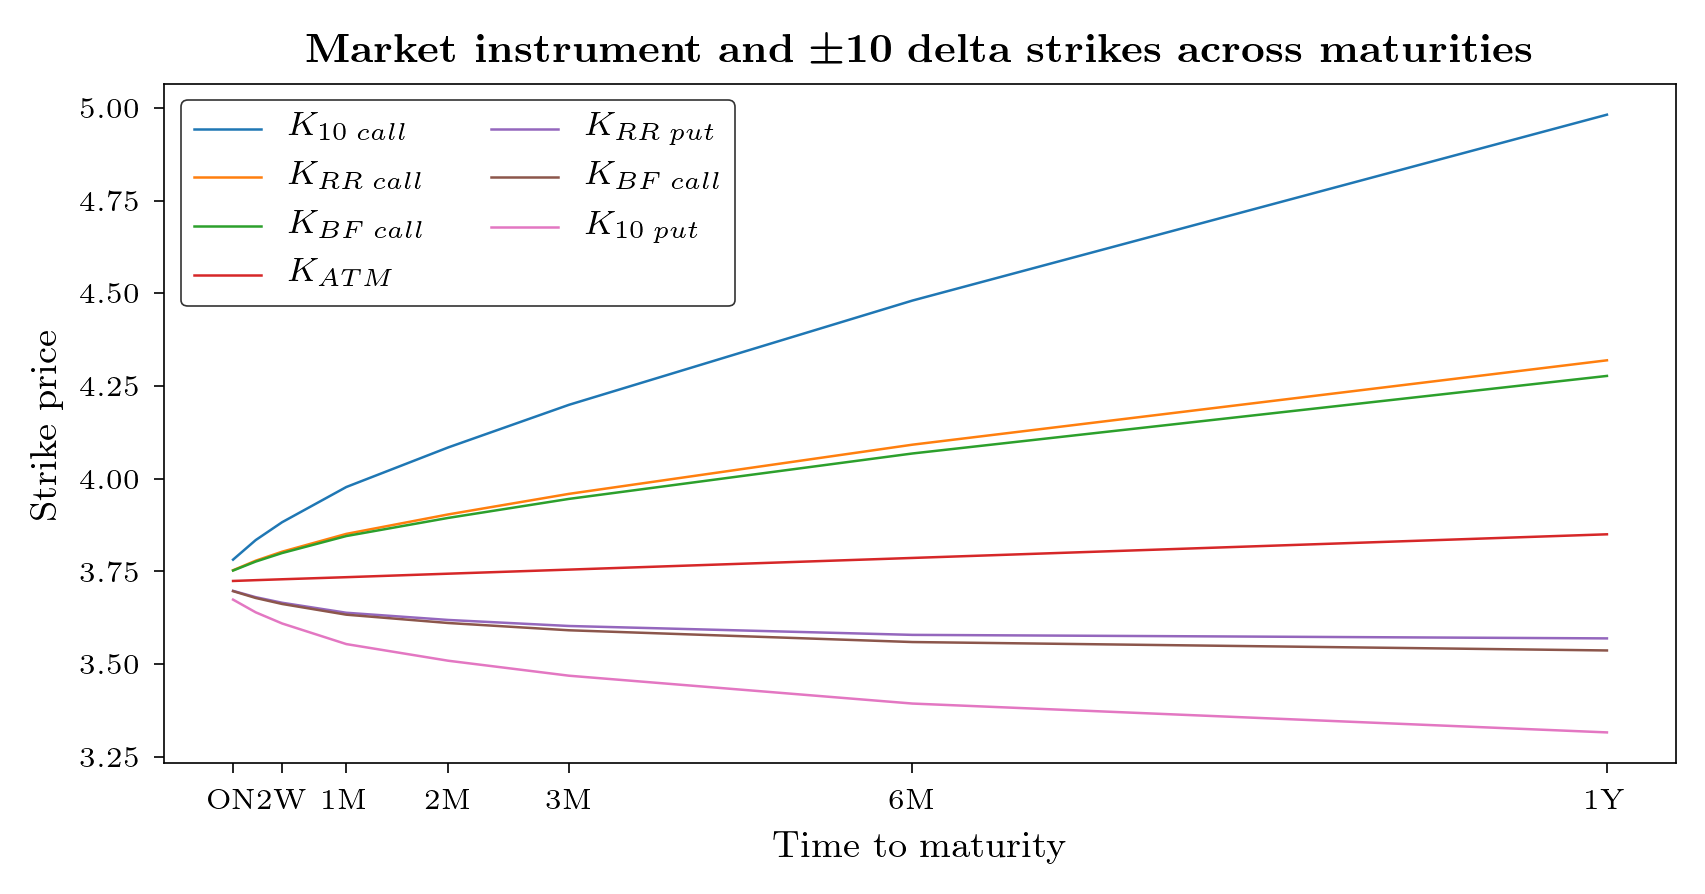

In [14]:
strikes_df = pd.DataFrame([sabr_answers[ans].strikes_dict for ans in sabr_answers], index=sabr_answers)

strikes_df["k_10_call"] = [sabr_answers[ans].fit_strike_from_delta(option_type="c", delta=0.1)
                           for ans in sabr_answers]
strikes_df["k_10_put"] = [sabr_answers[ans].fit_strike_from_delta(option_type="p", delta=-0.1)
                          for ans in sabr_answers]

strikes_df = strikes_df[["k_10_put", "k_bf_put", "k_rr_put", "k_atm", "k_bf_call", "k_rr_call", "k_10_call"]]

strike_labels = ['$K_{10 \; put}$', '$K_{BF \; call}$', '$K_{RR \; put}$', '$K_{ATM}$',
                 '$K_{BF \; call}$', '$K_{RR \; call}$', '$K_{10 \; call}$']

display(strikes_df)

plt.figure(figsize=(6.5,3), dpi=300)

for col, label in zip(strikes_df.columns[::-1], strike_labels[::-1]):
    plt.plot(inputs_df.mty, strikes_df[col], label=label)

plt.xticks(inputs_df.mty[[0,2,3,4,5,6,7]], strikes_df.index[[0,2,3,4,5,6,7]])
plt.xlabel("Time to maturity")
plt.ylabel("Strike price")

l = plt.legend(ncol=2).get_frame()
l.set_linewidth(0.4)
l.set_color("white")
l.set_edgecolor("k")

plt.title(r"\textbf{Market instrument and} $\boldsymbol{\pm10}$ \textbf{delta strikes across maturities}",
          fontsize=10)

if save_files:
    strikes_df.to_csv("csv/strikes_df.csv")
    plt.savefig("graphs/strikes.svg", bbox_inches="tight")

plt.show()

,vol_10_put,vol_bf_put,vol_rr_put,vol_atm,vol_bf_call,vol_rr_call,vol_10_call
ON,0.203988,0.205323,0.205407,0.2098,0.217160,0.217407,0.227053
1W,0.134198,0.134667,0.134778,0.1391,0.147326,0.147778,0.159496
2W,0.131568,0.132544,0.132695,0.1375,0.146186,0.146695,0.158853
1M,0.135935,0.137110,0.137284,0.1424,0.151727,0.152284,0.165283
2M,0.131131,0.132350,0.132586,0.1384,0.149318,0.150086,0.165689
3M,0.130048,0.131378,0.131685,0.1382,0.150696,0.151685,0.169893
6M,0.129279,0.130426,0.130835,0.1382,0.153433,0.154835,0.178115
1Y,0.128300,0.130120,0.130765,0.1394,0.157848,0.159765,0.188958


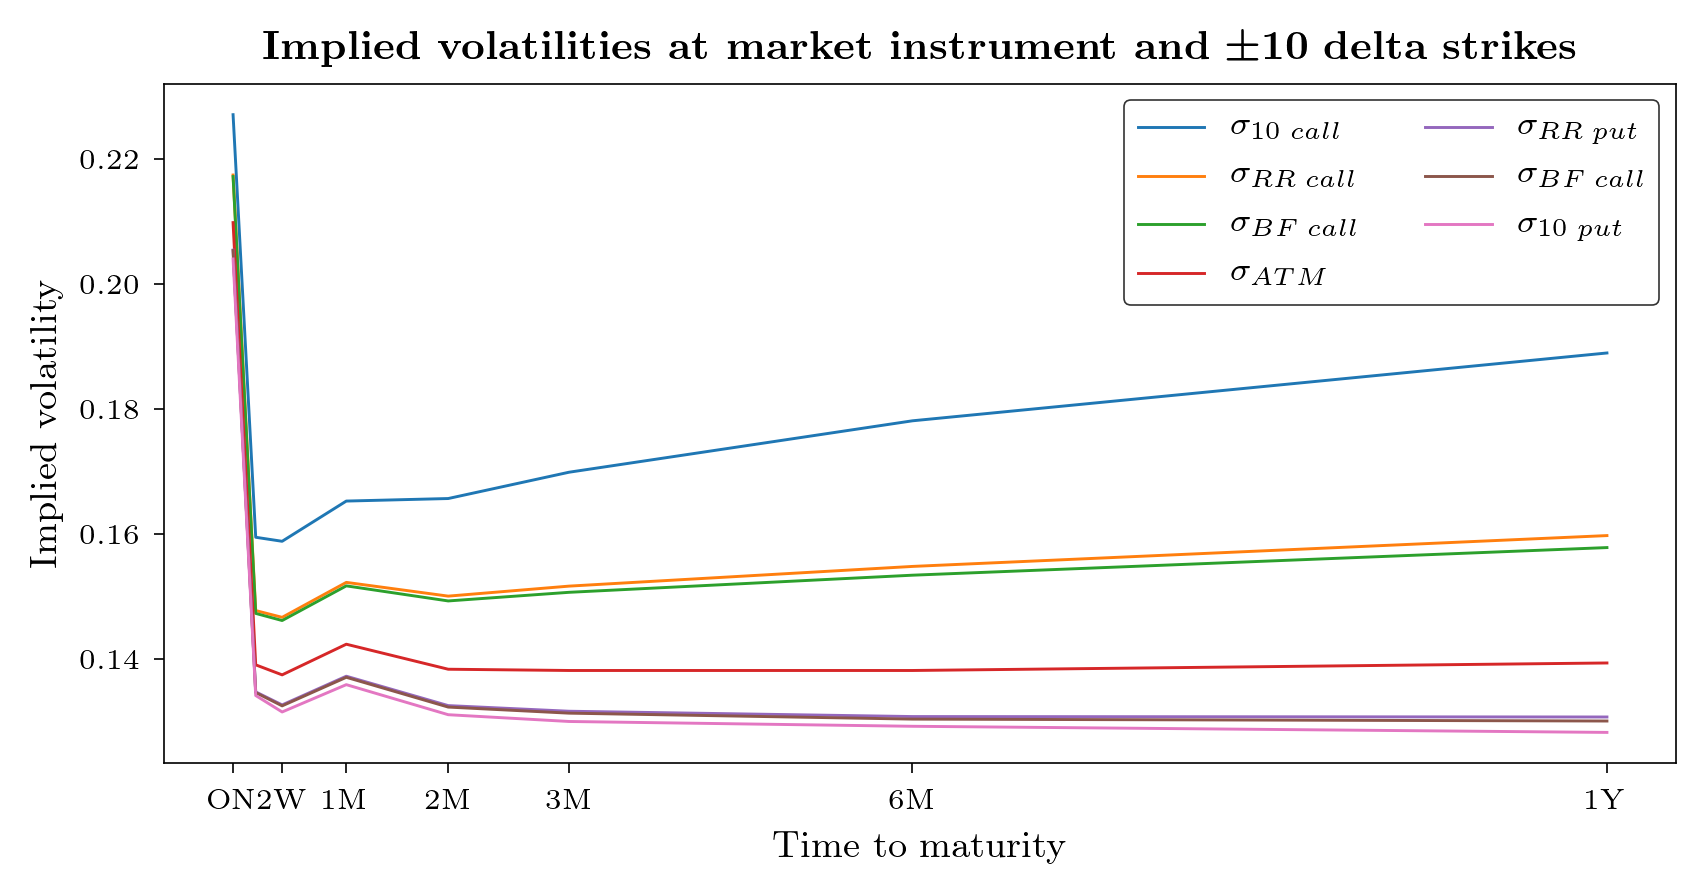

In [15]:
vols_df = pd.DataFrame([[sabr_answers[ans].implied_vol(strike=strike) for strike in strikes_df.loc[ans]]
                         for ans in sabr_answers], index=sabr_answers,
                       columns=["vol" + col[1:] for col in strikes_df])
display(vols_df)

vol_labels = ['$\sigma_{10 \; put}$', '$\sigma_{BF \; call}$', '$\sigma_{RR \; put}$', '$\sigma_{ATM}$',
              '$\sigma_{BF \; call}$', '$\sigma_{RR \; call}$', '$\sigma_{10 \; call}$']

plt.figure(figsize=(6.5,3), dpi=300)

for col, label in zip(vols_df.columns[::-1], vol_labels[::-1]):
    plt.plot(inputs_df.mty, vols_df[col], label=label, linewidth=0.7)

plt.xticks(inputs_df.mty[[0,2,3,4,5,6,7]], vols_df.index[[0,2,3,4,5,6,7]])
plt.xlabel("Time to maturity")
plt.ylabel("Implied volatility")

l = plt.legend(ncol=2).get_frame()
l.set_linewidth(0.4)
l.set_color("white")
l.set_edgecolor("k")

plt.title(r"\textbf{Implied volatilities at market instrument and} $\boldsymbol{\pm10}$ \textbf{delta strikes}",
          fontsize=10)

if save_files:
    vols_df.to_csv("csv/vols_df.csv")
    plt.savefig("graphs/vols.svg", bbox_inches="tight")
    
plt.show()

### Implied vol curves

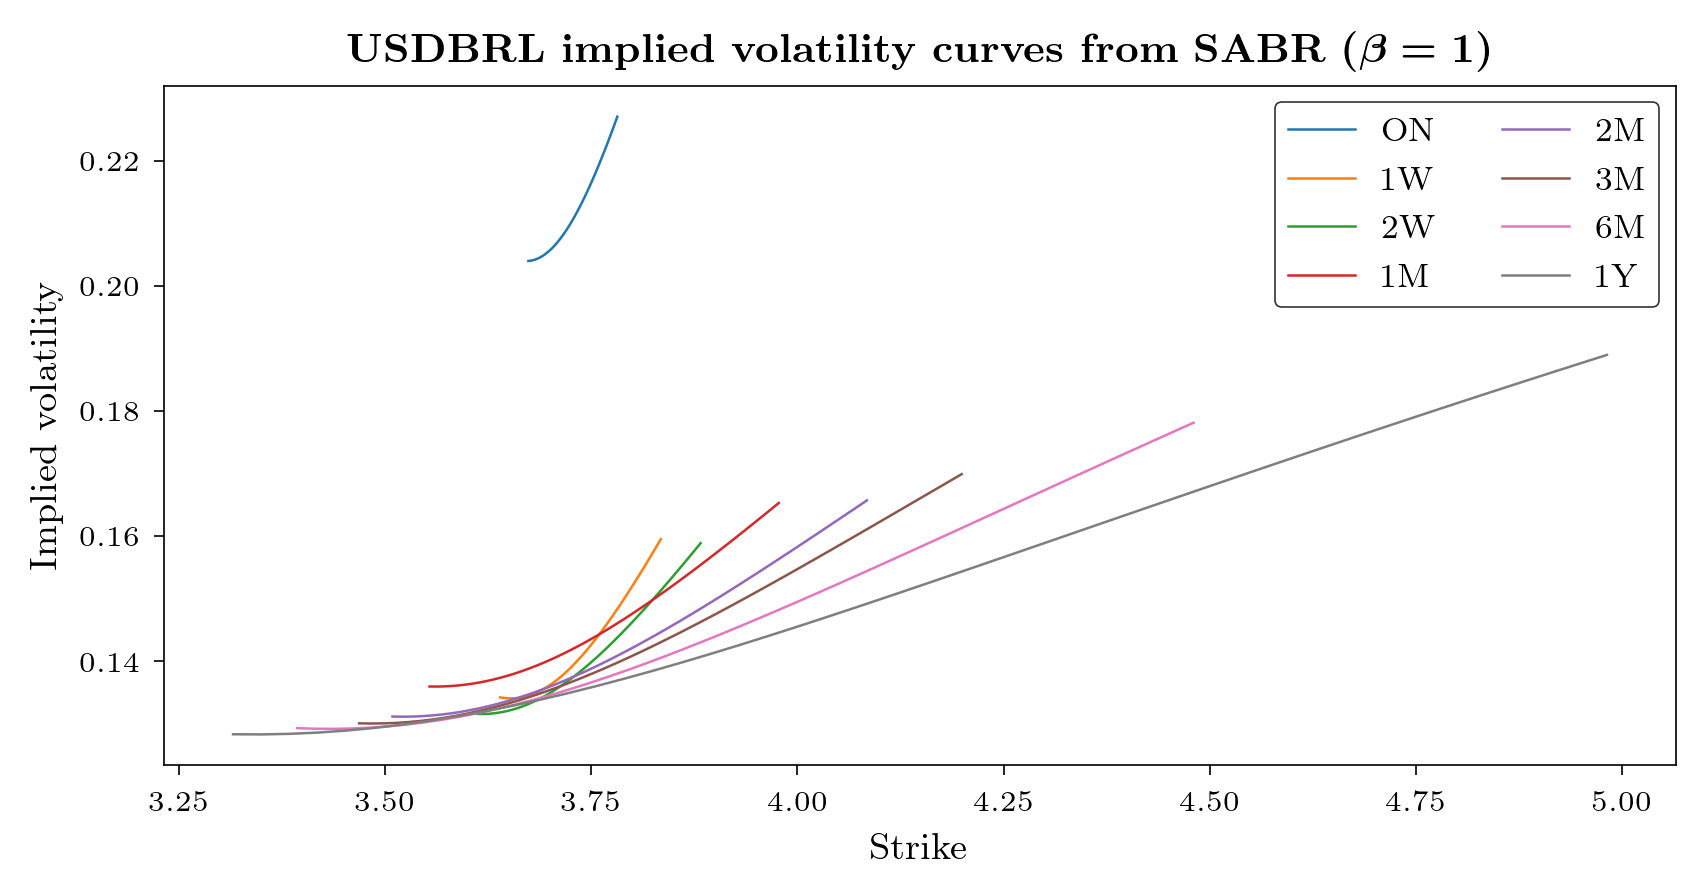

In [16]:
plt.figure(figsize=(6.5,3), dpi=300)

for tenor in sabr_answers:
    
    sabr = sabr_answers[tenor]
    sabr_strikes = np.linspace(sabr.fit_strike_from_delta("p", delta=-0.1),
                               stop=sabr.fit_strike_from_delta("c", delta=0.1))
    sabr_vols = [ sabr.implied_vol(strike) for strike in sabr_strikes ]

    plt.plot(sabr_strikes, sabr_vols, label=tenor)    
    
plt.xlabel("Strike")
plt.ylabel("Implied volatility")

l = plt.legend(ncol=2).get_frame()
l.set_linewidth(0.4)
l.set_color("white")
l.set_edgecolor("k")

plt.title(r"\textbf{USDBRL implied volatility curves from SABR} $\boldsymbol{(\beta = 1)}$",
          fontsize=10)

if save_files:
    plt.savefig("graphs/vol_curves_strike_2d.svg", bbox_inches="tight")
    
plt.show()

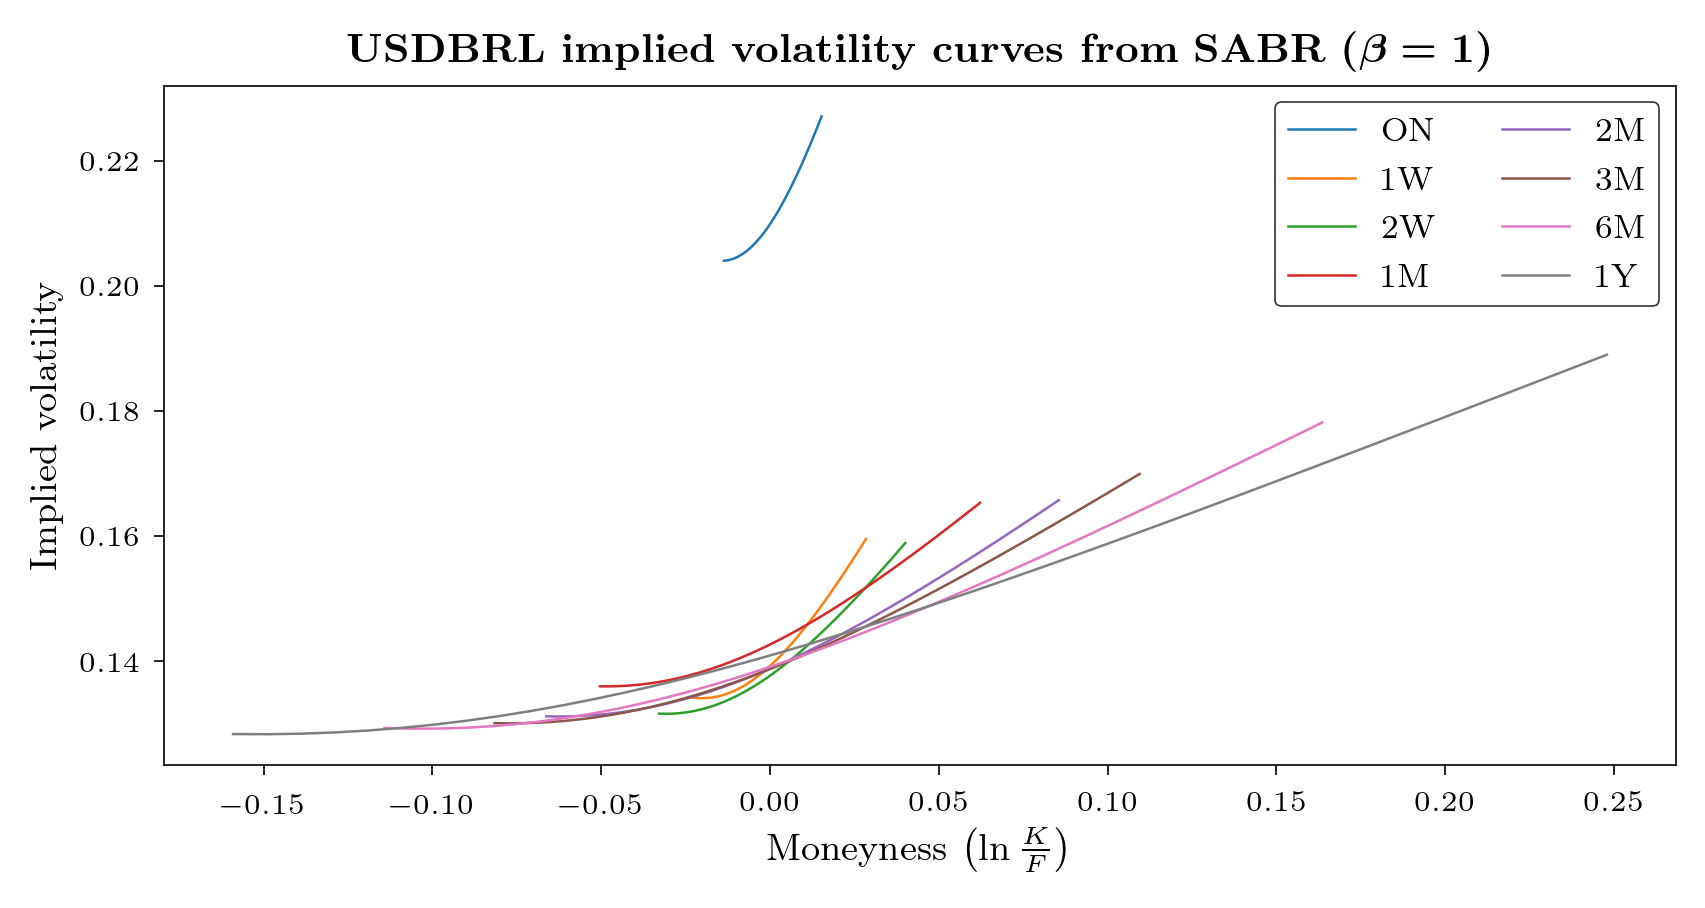

In [17]:
plt.figure(figsize=(6.5,3), dpi=300)

for tenor in sabr_answers:
    
    sabr = sabr_answers[tenor]
    sabr_strikes = np.linspace(sabr.fit_strike_from_delta("p", delta=-0.1),
                               stop=sabr.fit_strike_from_delta("c", delta=0.1))
    sabr_vols = [ sabr.implied_vol(strike) for strike in sabr_strikes ]

    plt.plot(np.log(sabr_strikes/sabr.forward), sabr_vols, label=tenor)

plt.xlabel(r"Moneyness $\left( \ln \frac{K}{F} \right)$")
plt.ylabel("Implied volatility")

l = plt.legend(ncol=2).get_frame()
l.set_linewidth(0.4)
l.set_color("white")
l.set_edgecolor("k")

plt.title(r"\textbf{USDBRL implied volatility curves from SABR} $\boldsymbol{(\beta = 1)}$",
          fontsize=10)

if save_files:
    plt.savefig("graphs/vol_curves_moneyness_2d.svg", bbox_inches="tight")

plt.show()

### Graph implied vol surface

Get surface data for $\pm$0.3 moneyness

In [18]:
X = []
Y = []
Z = []

n = 100
for tenor in list(sabr_answers.keys()):
    
    sabr = sabr_answers[tenor]
    X.append([sabr.mty] * n)
    
    y = np.linspace(start=-0.3, stop=0.3, num=n).tolist()
    Y.append(y)
    
    Z.append([ sabr.implied_vol(strike=np.exp(m)*sabr.forward) for m in y ])
    
X, Y, Z = np.array(X), np.array(Y), np.array(Z)

Create finer mesh of maturities, interpolate between maturities using flat forward interpolation described in Clark, 2011 (Foreign Exchange Option Pricing: A Practitioner's Guide)

In [19]:
XX = []
YY = []
ZZ = []

for mty in np.logspace(np.log10(X.min()), np.log10(X.max()), n):
    
    XX.append([mty] * n)
    
    yy = np.linspace(start=-0.3, stop=0.3, num=n).tolist()
    YY.append(yy)
    
    if mty in inputs_df.mty.values: 
        tenor = inputs_df.index[inputs_df.mty == mty][0]
        sabr = sabr_answers[tenor]
        
        ZZ.append([ sabr.implied_vol(strike=np.exp(m)*sabr.forward) for m in yy ])
        
    else:
        lower_tenor = inputs_df.index[inputs_df.mty <= mty][-1]
        higher_tenor = inputs_df.index[inputs_df.mty > mty][0]
        
        lower = sabr_answers[lower_tenor]
        higher = sabr_answers[higher_tenor]
        
        lower_mty = lower.mty
        higher_mty = higher.mty
        
        Z1 = [ lower.implied_vol(strike=np.exp(m)*lower.forward) for m in yy ]
        Z2 = [ higher.implied_vol(strike=np.exp(m)*higher.forward) for m in yy ]
        
        zz = []
        
        for i in range(n):
            lower_var = Z1[i] ** 2
            higher_var = Z2[i] ** 2
            
            var_forward = (higher_var * higher_mty - lower_var * lower_mty) / (higher_mty - lower_mty)
            
            z = np.sqrt((lower_var * lower_mty + var_forward * (mty - lower_mty)) / mty)
            zz.append(z)
        
        ZZ.append(zz)
    
XX, YY, ZZ = np.array(XX), np.array(YY), np.array(ZZ)

Generate $\pm$0.1 delta range and interpolate for intermediate maturities

In [20]:
method="linear"

X1 = inputs_df.mty.values
Y1 = np.array([np.log(strikes_df.loc[tenor, "k_10_call"] / sabr_answers[tenor].forward)
               for tenor in sabr_answers])

x1 = np.logspace(np.log10(X.min()), np.log10(X.max()), n)

y1 = interpolate.griddata(X1, Y1, x1, method=method)
z1 = interpolate.griddata((XX.flatten(), YY.flatten()), ZZ.flatten(), (x1, y1), method=method)

X2 = inputs_df.mty.values
Y2 = np.array([np.log(strikes_df.loc[tenor, "k_10_put"] / sabr_answers[tenor].forward)
               for tenor in sabr_answers])

x2 = np.logspace(np.log10(X.min()), np.log10(X.max()), n)
y2 = interpolate.griddata(X2, Y2, x2, method=method)
z2 = interpolate.griddata((XX.flatten(), YY.flatten()), ZZ.flatten(), (x2, y2), method=method)

Graph volatility surface and $\pm$0.1 delta range

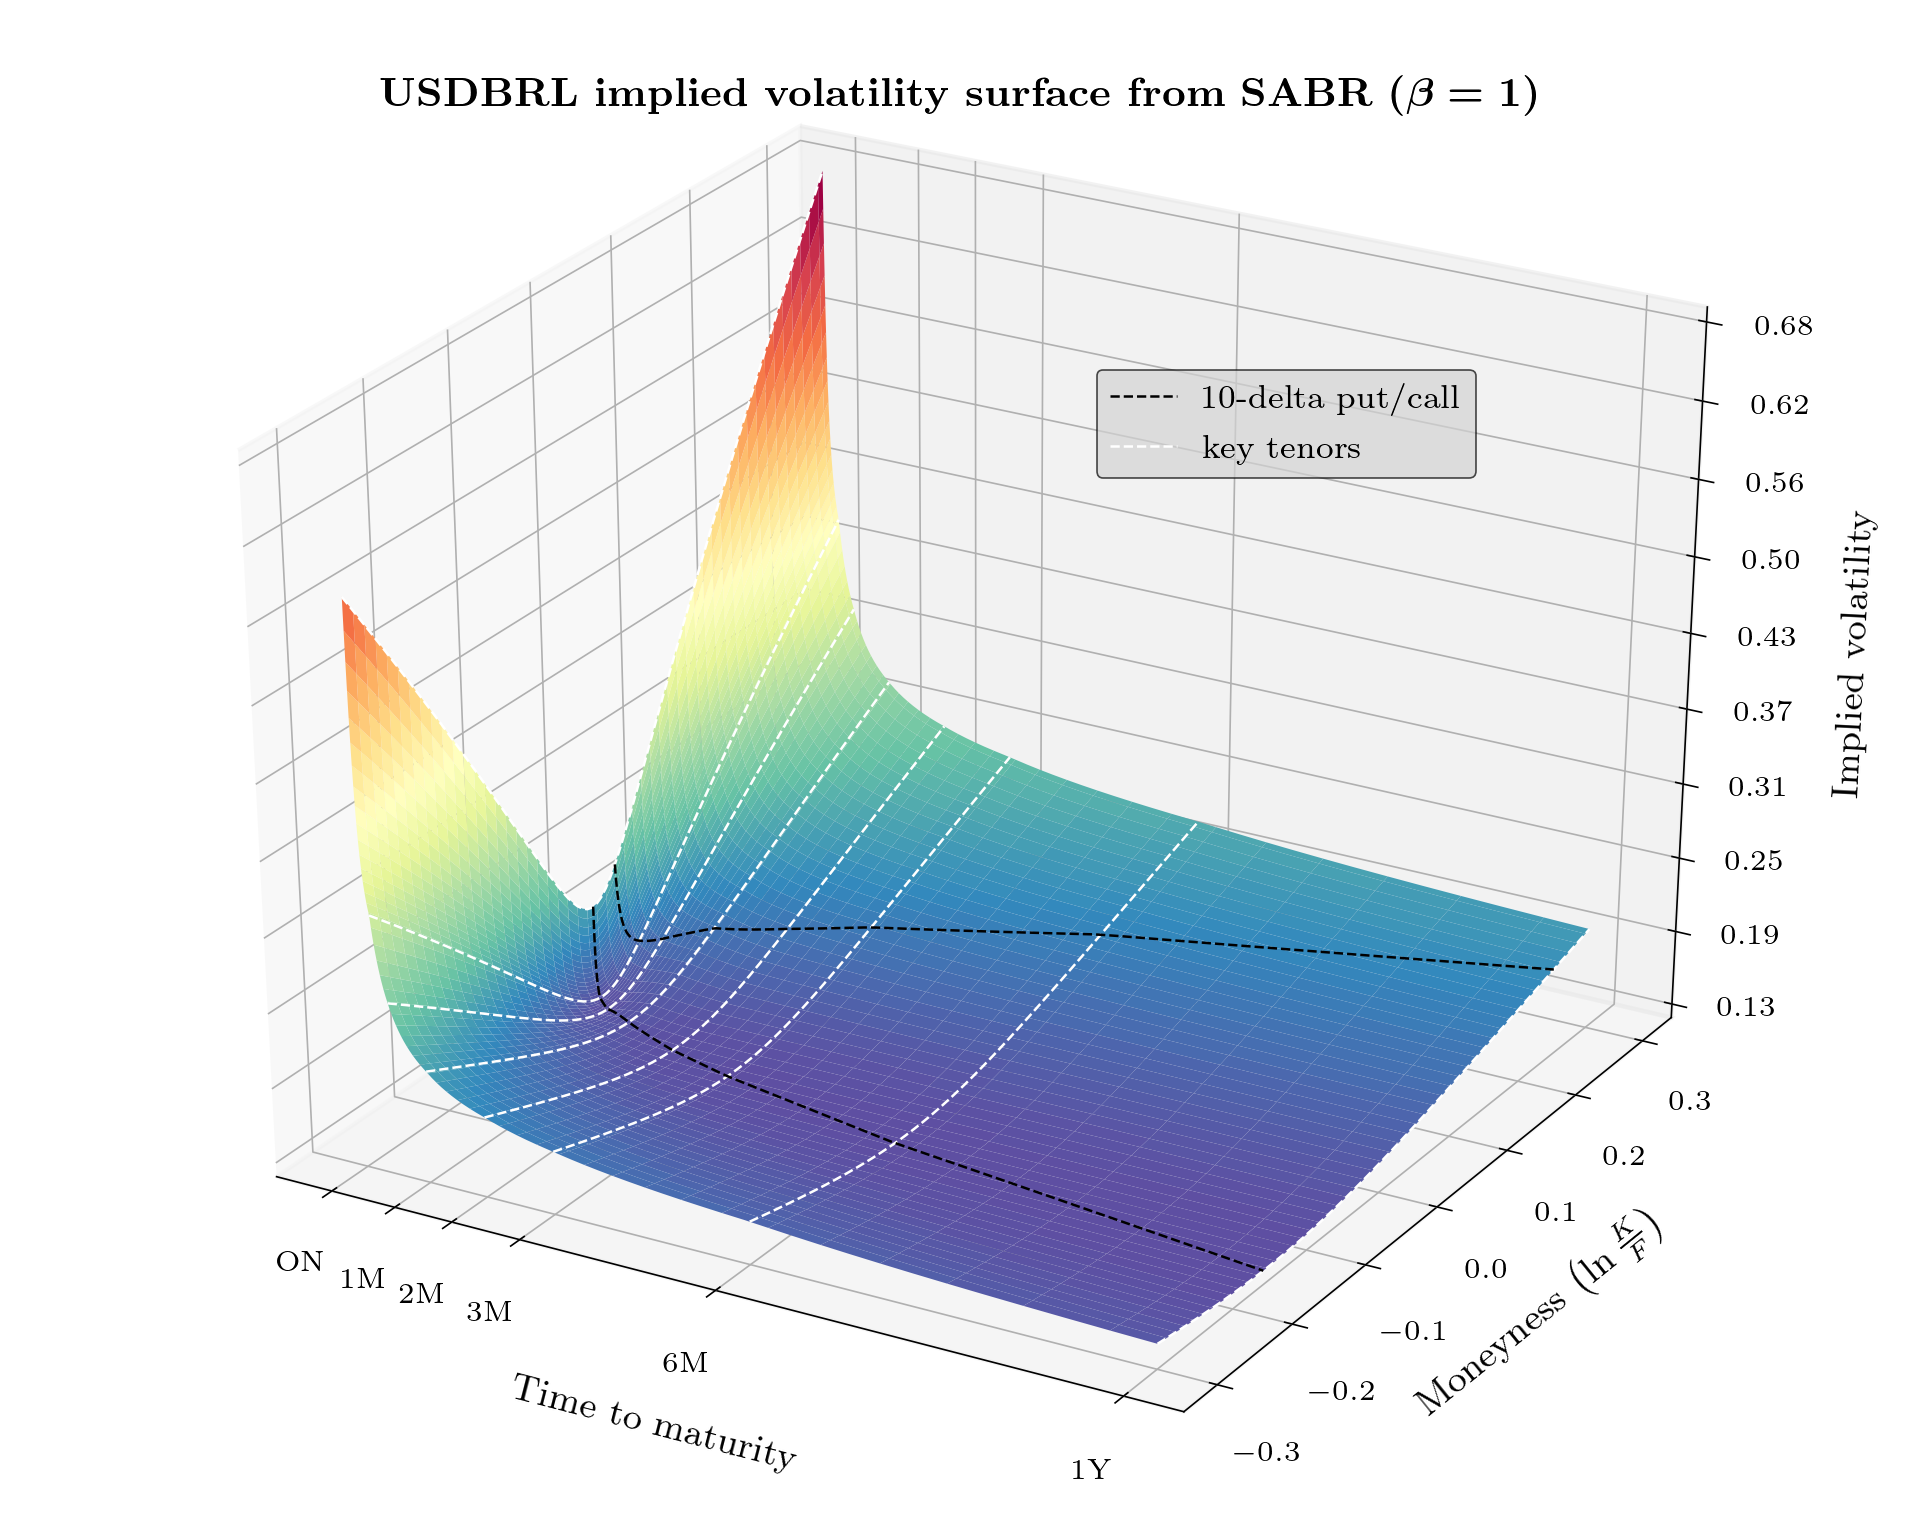

In [21]:
rcParams['grid.linewidth'] = 0.4
rcParams["legend.framealpha"] = 0.7
rcParams["legend.facecolor"] = "#d3d3d3"

fig = plt.figure(figsize=(8, 6.5), dpi=300)
ax = fig.gca(projection='3d')

ax.plot_surface(XX, YY, ZZ,
                alpha=1,
                cmap=cm.Spectral_r, antialiased=True)

ax.plot(x1, y1, z1, "--k", linewidth=0.6, zorder=300, label="10-delta put/call")
ax.plot(x2, y2, z2, "--k", linewidth=0.6, zorder=300)

ax.plot(X[0,:], Y[0,:], Z[0,:], "--w", zorder=200, linewidth=0.6, label="key tenors")
for x, y, z in zip(X[1:,:], Y[1:,:], Z[1:,:]):
    ax.plot(x, y, z, "--w", linewidth=0.6, zorder=200)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.set_xlabel("Time to maturity")
ax.set_ylabel(r"Moneyness $\left( \ln \frac{K}{F} \right)$")
ax.set_zlabel("Implied volatility")

ax.tick_params(axis='both', which='major')

plt.xticks(inputs_df.mty.iloc[[0,3,4,5,6,7]], strikes_df.index[[0,3,4,5,6,7]])

f = lambda x,y,z: proj3d.proj_transform(x,y,z, ax.get_proj())[:2]
ax.legend(bbox_to_anchor=f(0.6,0.6,0.5), 
          bbox_transform=ax.transData).get_frame().set_linewidth(0.4)

plt.title(r"\textbf{USDBRL implied volatility surface from SABR} $\boldsymbol{(\beta = 1)}$",
          fontsize=10, pad=10)


#ax.view_init(5,320)
if save_files:
    plt.savefig("graphs/vol_surface.svg", bbox_inches="tight")

plt.show()